[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

Too see plots run in google colab: https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

# Heterogeneous Array Mosaic Simulations and Imaging

In [1]:
import os
try:
    import sirius 
    print('SiRIUS version',sirius.__version__,'already installed.')
except:
    print('Installing SiRIUS')
    os.system("pip install sirius")
    import sirius 
    print('SiRIUS version',sirius.__version__,' installed.')

SiRIUS version 0.0.21 already installed.


In [2]:
import pkg_resources
import xarray as xr
import numpy as np
from astropy.coordinates import SkyCoord
xr.set_options(display_style="html")
import os
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
except:
    IN_COLAB = False
%matplotlib widget 
#%matplotlib inline

#working_dir = '/lustre/cv/users/jsteeb/simulation/'
working_dir = ''

## Telescope Layout

In [3]:
########## Get telescope layout ##########
tel_dir = pkg_resources.resource_filename('sirius_data', 'telescope_layout/data/alma.all.tel.zarr')
tel_xds = xr.open_zarr(tel_dir,consolidated=False).sel(ant_name = ['N601','N606','J505','J510', 'A001', 'A012','A025', 'A033','A045', 'A051','A065', 'A078'])
n_ant = tel_xds.dims['ant_name']
tel_xds

<xarray.Dataset>
Dimensions:        (ant_name: 12, pos_coord: 3)
Coordinates:
  * ant_name       (ant_name) <U7 'N601' 'N606' 'J505' ... 'A051' 'A065' 'A078'
  * pos_coord      (pos_coord) int64 0 1 2
Data variables:
    ANT_POS        (ant_name, pos_coord) float64 dask.array<chunksize=(12, 3), meta=np.ndarray>
    DISH_DIAMETER  (ant_name) float64 dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    site_pos:        [{'m0': {'unit': 'm', 'value': 2225142.180268967}, 'm1':...
    telescope_name:  ALMA

## Create Time and Freq Xarrays
The chunking of time_xda and chan_xda determines the number of branches in the DAG (maximum parallelism = n_time_chunks x n_chan_chunks).

In [4]:
from sirius.dio import make_time_xda 

#time_xda = make_time_xda(time_start='2020-10-03T18:56:36.44',time_delta=2000,n_samples=18,n_chunks=4)
#time_xda = make_time_xda(time_start='2020-10-03T18:57:29.09',time_delta=2000,n_samples=18,n_chunks=4)
#time_xda = make_time_xda(time_start='2020-10-04T00:00:00.000',time_delta=2000,n_samples=18,n_chunks=4)

#time_xda = make_time_xda(time_start='2020-10-03T18:57:28.95',time_delta=2000,n_samples=18,n_chunks=2)
time_xda = make_time_xda(time_start='2020-10-03T18:57:28.95',time_delta=2000,n_samples=18,n_chunks=1)
time_xda

Number of chunks  1


<xarray.DataArray 'array-a26c3c2e3ac33048ef565ef252d802d9' (time: 18)>
dask.array<array, shape=(18,), dtype=<U23, chunksize=(18,), chunktype=numpy.ndarray>
Dimensions without coordinates: time
Attributes:
    time_delta:  2000.0

In [5]:
from sirius.dio import make_chan_xda   #n_channels = 5
#chan_xda = make_chan_xda(spw_name = 'Band3',freq_start = 90*10**9, freq_delta = 2*10**9, freq_resolution=1*10**6, n_channels=5, n_chunks=2)
chan_xda = make_chan_xda(spw_name = 'Band3',freq_start = 90*10**9, freq_delta = 2*10**9, freq_resolution=1*10**6, n_channels=5, n_chunks=1)
chan_xda

Number of chunks  1


<xarray.DataArray 'array-0abbfd50a841ad468a340137153842c0' (chan: 5)>
dask.array<array, shape=(5,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>
Dimensions without coordinates: chan
Attributes:
    freq_resolution:  1000000.0
    spw_name:         Band3
    freq_delta:       2000000000.0

Beam Models

In [6]:
from sirius_data.beam_1d_func_models.airy_disk import alma, aca
airy_disk_parms_alma =  alma
airy_disk_parms_aca =  aca

print(alma)
print(aca)

beam_models = [airy_disk_parms_aca, airy_disk_parms_alma]

# beam_model_map maps the antenna index to a model in beam_models.
beam_model_map = tel_xds.DISH_DIAMETER.values  
beam_model_map[beam_model_map == 7] = 0
beam_model_map[beam_model_map == 12] = 1
beam_model_map= beam_model_map.astype(int)

beam_parms = {} #Use default beam parms.

{'func': 'casa_airy', 'dish_diam': 10.7, 'blockage_diam': 0.75, 'max_rad_1GHz': 0.03113667385557884}
{'func': 'casa_airy', 'dish_diam': 6.25, 'blockage_diam': 0.75, 'max_rad_1GHz': 0.06227334771115768}


## Polarization Setup

In [7]:
#https://github.com/casacore/casacore/blob/dbf28794ef446bbf4e6150653dbe404379a3c429/measures/Measures/Stokes.h
# ['RR','RL','LR','LL'] => [5,6,7,8], ['XX','XY','YX','YY'] => [9,10,11,12]
pol = [9,12] 

## UVW Parameters

In [8]:
# If using uvw_parms['calc_method'] = 'casa' .casarc must have directory of casadata. 
import pkg_resources
casa_data_dir = pkg_resources.resource_filename('casadata', '__data__')
rc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode
rc_file.write("\n measures.directory: " + casa_data_dir)
rc_file.close()

uvw_parms = {}
uvw_parms['calc_method'] = 'casa' #'astropy' or 'casa'Heterogeneous Array Mosaic Simulations and Imaging

## Sources
### point_source_ra_dec:  [n_time, n_point_sources, 2] (singleton: n_time)

In [9]:
point_source_skycoord = SkyCoord(ra='19h59m28.5s',dec='-40d44m21.5s',frame='fk5') 
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])[None,None,:]

### point_source_flux: [n_point_sources, n_time, n_chan, n_pol] (singleton: n_time, n_chan)
All 4 instramental pol values must be given even if only RR and LL are requested. 

In [10]:
point_source_flux = np.array([1.0, 0, 0, 1.0])[None,None,None,:] 

## Telescope Setup
### phase_center:  [n_time, 2] (singleton: n_time)
### phase_center_names: [n_time] (singleton: n_time)

In [11]:
n_time = len(time_xda)
n_time_per_field = int(n_time/2)
phase_center_1 = SkyCoord(ra='19h59m28.5s',dec='-40d44m01.5s',frame='fk5')
phase_center_2 = SkyCoord(ra='19h59m28.5s',dec='-40d44m51.5s',frame='fk5')
phase_center_names = np.array(['field1']*n_time_per_field + ['field2']*n_time_per_field)
phase_center_ra_dec = np.array([[phase_center_1.ra.rad,phase_center_1.dec.rad]]*n_time_per_field + [[phase_center_2.ra.rad,phase_center_2.dec.rad]]*n_time_per_field)

### pointing_ra_dec:[n_time, n_ant, 2]                   (singleton: n_time, n_ant) or None

In [12]:
pointing_ra_dec = None #No pointing offsets

## Run Simulation

In [13]:
noise_parms = None

from sirius import simulation
save_parms = {'ms_name':working_dir+'het_mosaic_sim.ms','write_to_ms':True}
vis_xds = simulation(point_source_flux, 
                     point_source_ra_dec, 
                     pointing_ra_dec, 
                     phase_center_ra_dec, 
                     phase_center_names, 
                     beam_parms,beam_models,
                     beam_model_map,uvw_parms, 
                     tel_xds, time_xda, chan_xda, pol, noise_parms, save_parms) 
vis_xds

Setting default auto_corr  to  False
Setting default fov_scaling  to  4.0
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]
Setting default DAG_name_vis_uvw_gen  to  False
Setting default DAG_name_write  to  False
Meta data creation  30.654367208480835
reshape time  0.00202178955078125
*** Dask compute time 10.297820568084717
compute and save time  10.298502206802368


[<xarray.Dataset>
 Dimensions:         (row: 594, chan: 5, corr: 2, uvw: 3)
 Coordinates:
     ROWID           (row) int32 dask.array<chunksize=(594,), meta=np.ndarray>
 Dimensions without coordinates: row, chan, corr, uvw
 Data variables: (12/21)
     TIME_CENTROID   (row) float64 dask.array<chunksize=(594,), meta=np.ndarray>
     SCAN_NUMBER     (row) int32 dask.array<chunksize=(594,), meta=np.ndarray>
     ANTENNA1        (row) int32 dask.array<chunksize=(594,), meta=np.ndarray>
     FEED1           (row) int32 dask.array<chunksize=(594,), meta=np.ndarray>
     INTERVAL        (row) float64 dask.array<chunksize=(594,), meta=np.ndarray>
     FLAG_ROW        (row) bool dask.array<chunksize=(594,), meta=np.ndarray>
     ...              ...
     UVW             (row, uvw) float64 dask.array<chunksize=(594, 3), meta=np.ndarray>
     TIME            (row) float64 dask.array<chunksize=(594,), meta=np.ndarray>
     FLAG            (row, chan, corr) bool dask.array<chunksize=(594, 5, 2), me

## Noise simulation

In [14]:
noise_parms = {'t_receiver':5000} #Increased receiver noise so that effect of noise is easy to see in plots.

from sirius import simulation
save_parms_noisy = {'ms_name':working_dir+'het_mosaic_sim_noisy.ms','write_to_ms':True}
vis_xds = simulation(point_source_flux, 
                     point_source_ra_dec, 
                     pointing_ra_dec, 
                     phase_center_ra_dec, 
                     phase_center_names, 
                     beam_parms,beam_models,
                     beam_model_map,uvw_parms, 
                     tel_xds, time_xda, chan_xda, pol, noise_parms, save_parms_noisy) 
vis_xds

Setting default auto_corr  to  False
Setting default fov_scaling  to  4.0
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]
Setting default t_atmos  to  250.0
Currently the effect of Zenith Atmospheric Opacity (Tau) is not included in the noise modeling.
Setting default tau  to  0.1
Setting default ant_efficiency  to  0.8
Setting default spill_efficiency  to  0.85
Setting default corr_efficiency  to  0.88
Setting default t_ground  to  270.0
Setting default t_cmb  to  2.725
Setting default DAG_name_vis_uvw_gen  to  False
Setting default DAG_name_write  to  False
Meta data creation  15.82155966758728
reshape time  0.0019490718841552734
*** Dask compute time 0.3486812114715576
compute and save time  0.3488438129425049


[<xarray.Dataset>
 Dimensions:         (row: 594, chan: 5, corr: 2, uvw: 3)
 Coordinates:
     ROWID           (row) int32 dask.array<chunksize=(594,), meta=np.ndarray>
 Dimensions without coordinates: row, chan, corr, uvw
 Data variables: (12/21)
     TIME_CENTROID   (row) float64 dask.array<chunksize=(594,), meta=np.ndarray>
     SCAN_NUMBER     (row) int32 dask.array<chunksize=(594,), meta=np.ndarray>
     ANTENNA1        (row) int32 dask.array<chunksize=(594,), meta=np.ndarray>
     FEED1           (row) int32 dask.array<chunksize=(594,), meta=np.ndarray>
     INTERVAL        (row) float64 dask.array<chunksize=(594,), meta=np.ndarray>
     FLAG_ROW        (row) bool dask.array<chunksize=(594,), meta=np.ndarray>
     ...              ...
     UVW             (row, uvw) float64 dask.array<chunksize=(594, 3), meta=np.ndarray>
     TIME            (row) float64 dask.array<chunksize=(594,), meta=np.ndarray>
     FLAG            (row, chan, corr) bool dask.array<chunksize=(594, 5, 2), me

## Analysis

### Plot Antennas

In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
from sirius.display_tools import x_plot

Completed ddi 0  process time 4.26 s.ATA...SPECTRAL_WINDOW_ID...                    
Completed subtables  process time 6.16 s...                                     
                                                  
overwrite_encoded_chunks True


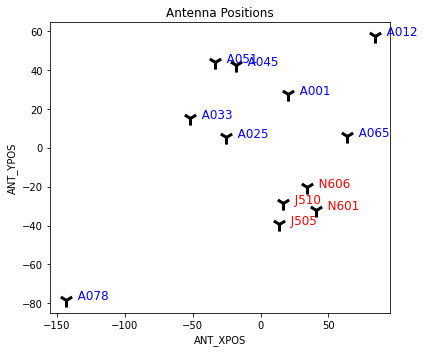

In [17]:
x_plot(vis=save_parms['ms_name'], ptype='plotants')

Completed ddi 0  process time 4.28 s.ATA...SPECTRAL_WINDOW_ID...                    
Completed subtables  process time 6.53 s...                                     
                                                  
overwrite_encoded_chunks True


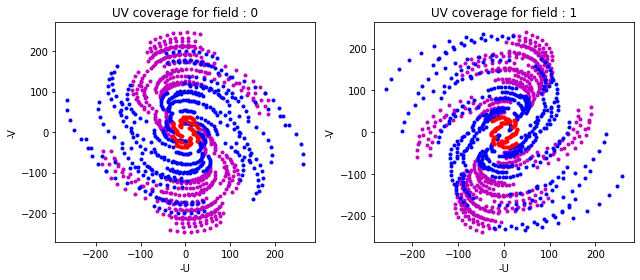

In [18]:
from sirius.display_tools import x_plot
x_plot(vis=save_parms['ms_name'], ptype='uvcov',forceconvert=True)

In [19]:
from sirius.display_tools import listobs_jupyter
listobs_jupyter(vis=save_parms['ms_name'])

           MeasurementSet Name:  /lustre/cv/users/jsteeb/simulation/het_mosaic_sim.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: ALMA(12 antennas)
Data records: 1188       Total elapsed time = 36000 seconds
   Observed from   03-Oct-2020/18:40:49.0   to   04-Oct-2020/04:40:48.9 (UTC)

Fields: 2
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         field1              19:59:28.500000 -40.44.01.50000 J2000   0            594
  1         field2              19:59:28.500000 -40.44.51.50000 J2000   1            594
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      Band3      5   LSRK   90000.000   2000000.000  10000000.0  94000.0000   XX  YY
Antennas: 12 'name'='station' 
   ID=   0-4: 'N601'='P', 'N606'='P', 'J505'='P', 'J510'='P', 'A001'='P', 
   ID=   5-9: 'A012'='P', 

overwrite_encoded_chunks True


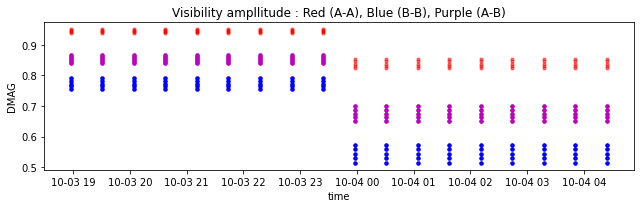

In [20]:
x_plot(vis=save_parms['ms_name'], ptype='amp-time')

overwrite_encoded_chunks True


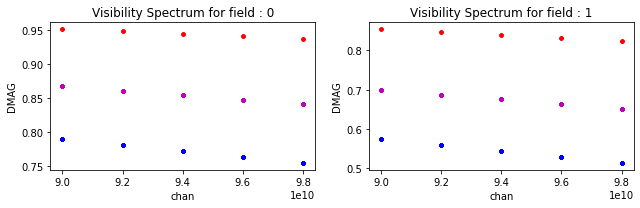

In [21]:
from sirius.display_tools import x_plot
x_plot(vis=save_parms['ms_name'], ptype='amp-freq')

Completed ddi 0  process time 4.20 s.ATA...SPECTRAL_WINDOW_ID...                    
Completed subtables  process time 6.73 s...                                     
                                                  
overwrite_encoded_chunks True


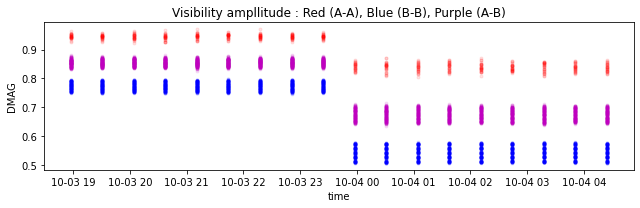

In [22]:
from sirius.display_tools import x_plot
x_plot(vis=save_parms_noisy['ms_name'], ptype='amp-time')

overwrite_encoded_chunks True


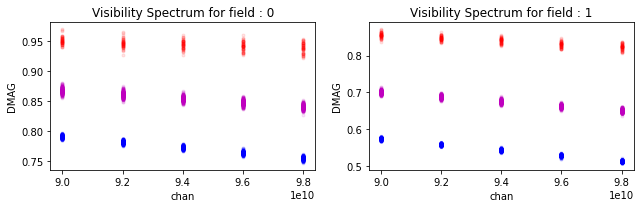

In [23]:
from sirius.display_tools import x_plot
x_plot(vis=save_parms_noisy['ms_name'], ptype='amp-freq')

## Imaging

This will take a while. 

In [24]:
from sirius.display_tools import image_ants

image_ants(vis=save_parms_noisy['ms_name'],imname=working_dir+'try_ALMA', field='0',antsel='A')
image_ants(vis=save_parms_noisy['ms_name'],imname=working_dir+'try_ALMA', field='0',antsel='B')
image_ants(vis=save_parms_noisy['ms_name'],imname=working_dir+'try_ALMA', field='0',antsel='cross')
image_ants(vis=save_parms_noisy['ms_name'],imname=working_dir+'try_ALMA', field='0',antsel='all')

antsels[antsel]2  A*&
antsels[antsel]2  J*,N*&
antsels[antsel]2  A* && J*,N*
antsels[antsel]2  *


### 12m-12m
Image only the 12m-12m baselines, with one pointing. The source is located at about the 0.78 gain level of the PB. For this 1 Jy source, the image and PB values should match.

Peak Intensity (chan0) : 0.7950903
PB at location of Intensity peak (chan0) : 0.7841024
max pixel location  (array([512]), array([512]), array([0]), array([0]))
Residual RMS : 0.0002087


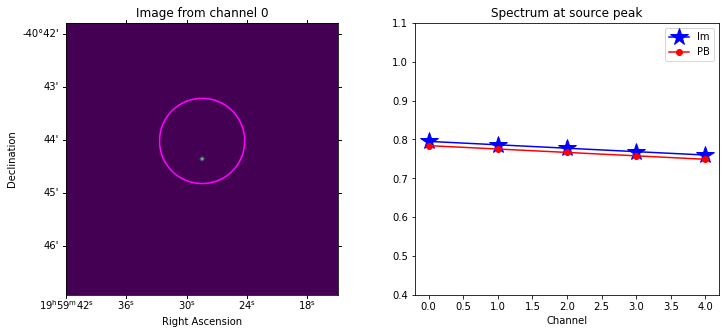

In [26]:
from sirius.display_tools import display_image
peak_12m,rms_12m = display_image(imname=working_dir+'try_ALMA_A_single.image',pbname=working_dir+'try_ALMA_A_single.pb',resname=working_dir+'try_ALMA_A_single.residual')

### 7m-7m

Image only the 7m-7m baselines, with one pointing. The PB is bigger than with the 12m and the source is located at about the 0.92 gain level of the PB. For this 1 Jy source, the image and PB values should match. 

Peak Intensity (chan0) : 0.9630291
PB at location of Intensity peak (chan0) : 0.9377817
max pixel location  (array([512]), array([512]), array([0]), array([0]))
Residual RMS : 0.0002087


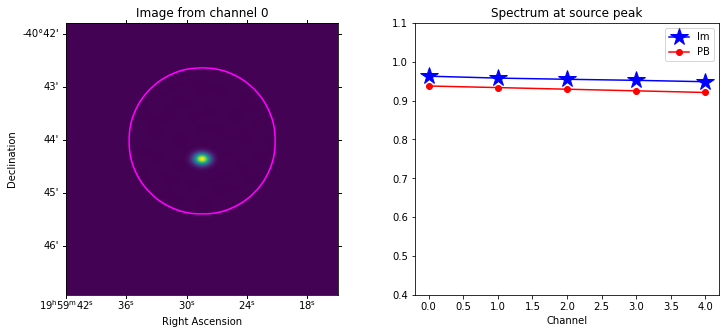

In [27]:
from sirius.display_tools import display_image
peak_7m,rms_7m = display_image(imname=working_dir+'try_ALMA_B_single.image',pbname=working_dir+'try_ALMA_B_single.pb',resname=working_dir+'try_ALMA_A_single.residual')

### 12m-7m

Peak Intensity (chan0) : 0.8732699
PB at location of Intensity peak (chan0) : 0.8572145
max pixel location  (array([512]), array([512]), array([0]), array([0]))
Residual RMS : 0.0002631


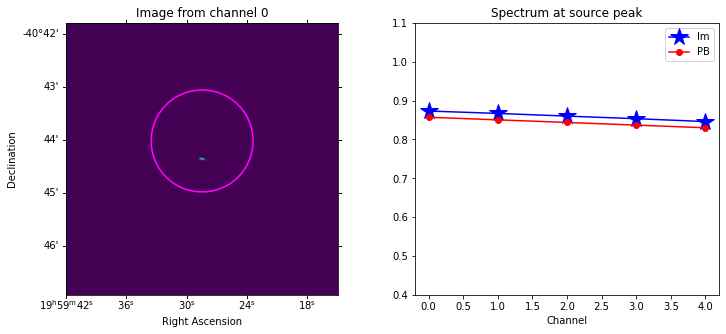

In [29]:
peak_cross, rms_cross = display_image(imname=working_dir+'try_ALMA_cross_single.image',pbname=working_dir+'try_ALMA_cross_single.pb',resname=working_dir+'try_ALMA_cross_single.residual')

### All baselines together
Image all baselines. 

Peak Intensity (chan0) : 0.8205988
PB at location of Intensity peak (chan0) : 0.8077468
max pixel location  (array([512]), array([512]), array([0]), array([0]))
Residual RMS : 0.0001830


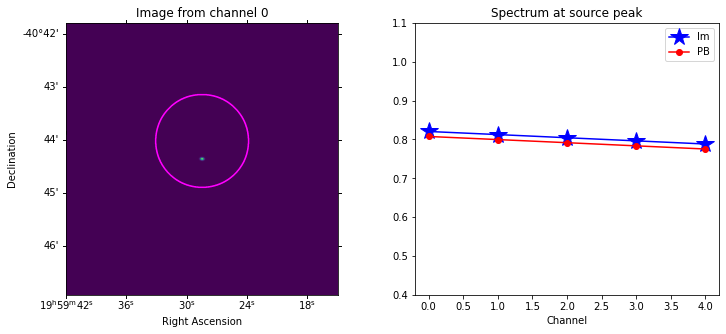

In [28]:
peak_all, rms_all = display_image(imname=working_dir+'try_ALMA_all_single.image',pbname=working_dir+'try_ALMA_all_single.pb',resname=working_dir+'try_ALMA_all_single.residual')

### Verify the measured intensity, PB and noise levels.

In [30]:
from sirius.display_tools import get_baseline_types, check_vals
from casatasks import mstransform
 ## Add the WEIGHT_SPECTRUM column. This is needed only if you intend to use task_visstat on this dataset.
os.system('rm -rf het_sim_weight_spectrum.ms')
mstransform(vis=save_parms_noisy['ms_name'],outputvis=working_dir+'het_sim_weight_spectrum.ms',datacolumn='DATA',usewtspectrum=True)


antsels = get_baseline_types()
meas_peaks = {'A':peak_12m, 'B':peak_7m, 'cross':peak_cross, 'all':peak_all}
meas_rms = {'A':rms_12m, 'B':rms_7m, 'cross':rms_cross, 'all':rms_all}
check_vals(vis=working_dir+'het_sim_weight_spectrum.ms',field='0',spw='0:0',antsels=antsels,meas_peaks=meas_peaks, meas_rms=meas_rms)

,Baseline Types,Vis Mean (V=I=P),Vis Std (sim),Vis Std (norm sim),Vis Std (calc),Number of Data Pts,Weight (calc),Weight (sim),Int Jy/bm (calc),Int Jy/bm (meas),RMS mJy (calc),RMS mJy (meas)
0,12m-12m,0.7912,0.0034,1.0000,1.0000,504.0000,1.0000,82754.9141,0.7912,0.7951,0.1515,0.2087
1,7m-7m,0.9514,0.0099,2.9132,2.9388,108.0000,0.1158,9633.3809,0.9514,0.9630,0.9536,0.2087
2,12m-7m,0.8679,0.0060,1.7770,1.7143,576.0000,0.3403,28234.9004,0.8676,0.8733,0.2519,0.2631
3,All,-NA-,-NA-,-NA-,-NA-,-NA,-NA-,-NA-,0.8152,0.8206,0.1287,0.1830


Calculated PB size for type A (dia=12.00) : 0.95493 arcmin
Calculated PB size for type B (dia=7.00) : 1.63702 arcmin


## Run the Imaging tests for a Mosaic
The tests below cover joint mosaic imaging. 

In [31]:
image_ants(vis=save_parms_noisy['ms_name'],imname=working_dir+'try_ALMA', field='0,1',antsel='A')
image_ants(vis=save_parms_noisy['ms_name'],imname=working_dir+'try_ALMA', field='0,1',antsel='B')
image_ants(vis=save_parms_noisy['ms_name'],imname=working_dir+'try_ALMA', field='0,1',antsel='cross')
image_ants(vis=save_parms_noisy['ms_name'],imname=working_dir+'try_ALMA', field='0,1',antsel='all')

antsels[antsel]2  A*&
antsels[antsel]2  J*,N*&
antsels[antsel]2  A* && J*,N*
antsels[antsel]2  *


### 12m-12m
Image only the 12m-12m baselines for a joint mosaic. For this 1 Jy source, the image and the PB values match. 

Peak Intensity (chan0) : 0.9638311
PB at location of Intensity peak (chan0) : 0.9509934
max pixel location  (array([512]), array([512]), array([0]), array([0]))
Residual RMS : 0.0001933


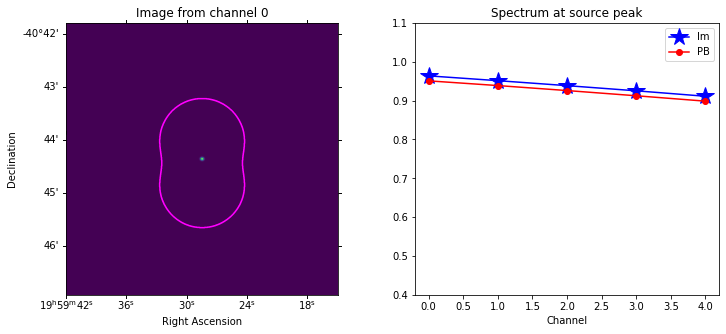

In [32]:
mospeak_12m,mosrms_12m = display_image(imname=working_dir+'try_ALMA_A_mosaic.image',pbname=working_dir+'try_ALMA_A_mosaic.pb',resname=working_dir+'try_ALMA_A_mosaic.residual')

### 7m-7m
Image only the 7m-7m baselines for a joint mosaic. For this 1 Jy source, the image and the PB values match. 

Peak Intensity (chan0) : 1.0191978
PB at location of Intensity peak (chan0) : 0.9956154
max pixel location  (array([512]), array([512]), array([0]), array([4]))
Residual RMS : 0.0009187


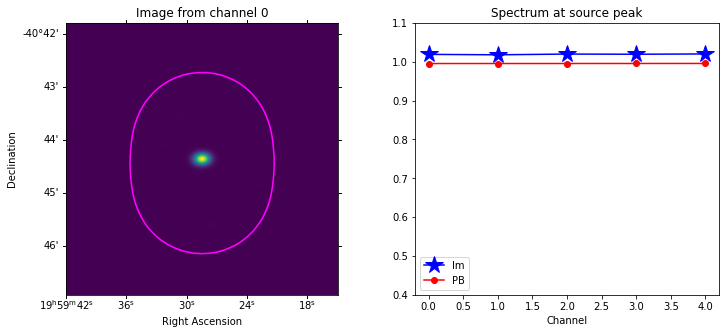

In [33]:
mospeak_7m,mosrms_7m = display_image(imname=working_dir+'try_ALMA_B_mosaic.image',pbname=working_dir+'try_ALMA_B_mosaic.pb',resname=working_dir+'try_ALMA_B_mosaic.residual')

### 12m-7m 
Image the cross baselines and check that the values of Sky, PB and RMS match the predictions. 

Peak Intensity (chan0) : 1.0148087
PB at location of Intensity peak (chan0) : 0.9982338
max pixel location  (array([512]), array([512]), array([0]), array([4]))
Residual RMS : 0.0002494


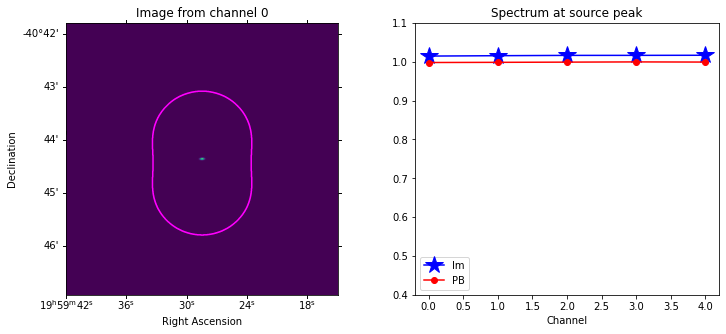

In [34]:
mospeak_cross,mosrms_cross = display_image(imname=working_dir+'try_ALMA_cross_mosaic.image',pbname=working_dir+'try_ALMA_cross_mosaic.pb',resname=working_dir+'try_ALMA_cross_mosaic.residual')

### All baselines together

Image all baselines together with a mosaic. 

Peak Intensity (chan0) : 0.9926163
PB at location of Intensity peak (chan0) : 0.9780214
max pixel location  (array([512]), array([512]), array([0]), array([0]))
Residual RMS : 0.0001611


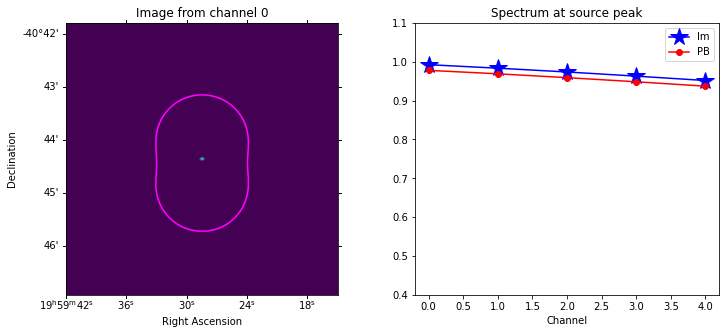

In [35]:
mospeak_all,mosrms_all = display_image(imname=working_dir+'try_ALMA_all_mosaic.image',pbname=working_dir+'try_ALMA_all_mosaic.pb',resname=working_dir+ 'try_ALMA_all_mosaic.residual')